In [1]:
import pandas as pd
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install haversine

### 1. 서울시 행정구역 불러오기

In [4]:
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde
from scipy.spatial import distance_matrix
!pip install pulp
from pulp import LpMaximize, LpProblem, LpVariable, lpSum
import geopandas as gpd
from shapely.geometry import Point
import folium
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 102.1 MB/s eta 0:00:00


In [5]:

# 행정동 geojson 파일을 읽고, 좌표 정보 읽어오기
path = "/content/drive/MyDrive/co-data/서울_행정동_경계_2017.geojson"

with open(path, encoding='utf-8') as json_file:
    jdata = json_file.read()
    geoJSON = json.loads(jdata)

pts=[]
for  feature in geoJSON['features']:
    if feature['geometry']['type']=='Polygon':
        pts.extend(feature['geometry']['coordinates'][0])
        pts.append([None, None])

    elif feature['geometry']['type']=='MultiPolygon':
        for polyg in feature['geometry']['coordinates']:
            pts.extend(polyg[0])
            pts.append([None, None])
    else: raise ValueError("geometry type irrelevant for map")


In [6]:
m = folium.Map(
    location=[37.52408, 126.9802],
    zoom_start=11,
)

folium.GeoJson(geoJSON, name='지역구').add_to(m)


m

### 2. 각 행정구역에 2023년도 병원 매핑하기 (총 3개의 클러스터가 나옴)

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50948 (\N{HANGUL SYLLABLE WI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50836 (\N{HANGUL SYLLABLE YO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47049 (\N{HANGUL SYLLABLE RYANG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/lo

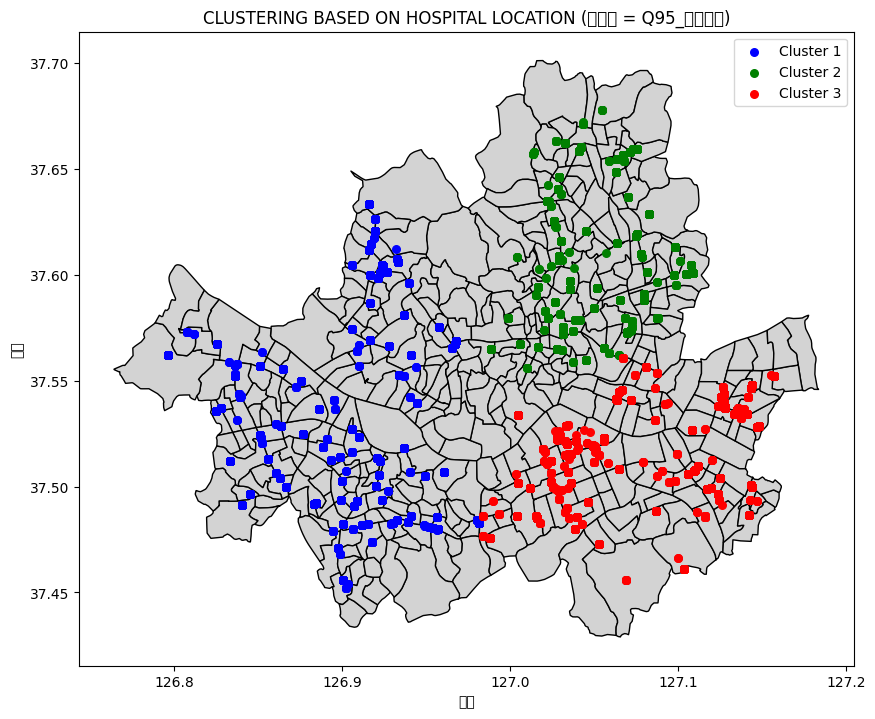

In [14]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from sklearn.cluster import KMeans

# 1. 병원 데이터 로드 (Q95 수요량 포함된 파일)
df = pd.read_csv('/content/drive/MyDrive/co-data/FINAL_BLOOD_RELEASE_2023_WITH_Q95.csv', encoding='cp949')

# 2. GeoJSON (행정경계) 불러오기 (geoJSON 객체가 메모리에 있다고 가정)
geo_gdf = gpd.GeoDataFrame.from_features(geoJSON["features"])
geo_gdf = geo_gdf.rename(columns={"adm_nm": "행정동"})
geo_gdf = geo_gdf.set_crs(epsg=4326)

# 3. 병원 위치 geometry 생성
df["geometry"] = df.apply(lambda row: Point(row["병원경도"], row["병원위도"]), axis=1)
hospital_gdf = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")

# 4. 병원 → 행정동 매핑
hospital_gdf = gpd.sjoin(hospital_gdf, geo_gdf, how="left", predicate="within")

# 5. 행정동별 출고건수 합계 (수요 분석용)
if "출고건수" in hospital_gdf.columns:
    demand_by_region = hospital_gdf.groupby("행정동")["출고건수"].sum().reset_index()
else:
    print("⚠️ '출고건수' 컬럼이 없습니다. 수요 분석 스킵합니다.")

# 6. 수요량을 Q95_출고건수로 설정
if "Q95_출고건수" in df.columns:
    df['수요량'] = df['Q95_출고건수']
else:
    raise ValueError("❌ Q95_출고건수 컬럼이 존재하지 않습니다. 확인해주세요.")

# 7. 병원별 고유 위치 추출 (중복 제거)
df_unique = df[['기관명', '병원경도', '병원위도']].drop_duplicates()

# 8. 병원 위치 기반 KMeans 클러스터링
kmeans = KMeans(n_clusters=3, random_state=42)
df_unique['클러스터'] = kmeans.fit_predict(df_unique[['병원경도', '병원위도']])

# 9. 클러스터 정보 병원 데이터에 병합
df = df.merge(df_unique[['기관명', '클러스터']], on='기관명', how='left')

# 10. GeoDataFrame 변환 (시각화용)
df_gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['병원경도'], df['병원위도']), crs="EPSG:4326")

# 11. 서울시 행정경계 GeoJSON 로드
path = "/content/drive/MyDrive/co-data/서울_행정동_경계_2017.geojson"
gdf = gpd.read_file(path)

# 12. 시각화
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, color='lightgray', edgecolor='black')  # 배경 지도

# 클러스터별 병원 위치 표시
colors = {0: 'blue', 1: 'green', 2: 'red'}
for cl, color in colors.items():
    df_gdf[df_gdf['클러스터'] == cl].plot(ax=ax, color=color, label=f'Cluster {cl + 1}', markersize=30)

plt.legend()
plt.title("CLUSTERING BASED ON HOSPITAL LOCATION (수요량 = Q95_출고건수)")
plt.xlabel("경도")
plt.ylabel("위도")
plt.show()



In [12]:
import pandas as pd
from sklearn.cluster import KMeans

# 1. 데이터 로드
df = pd.read_csv('/content/drive/MyDrive/co-data/FINAL_BLOOD_RELEASE_WITH_CLUSTER_2023_WITH_Q95.csv')

# 3. 병원별로 위치 기준 유일 병원 데이터 만들기
df_unique = df[['기관명', '병원경도', '병원위도']].drop_duplicates()

# 4. KMeans 클러스터링 (위치 기반)
kmeans = KMeans(n_clusters=3, random_state=42)
df_unique['클러스터'] = kmeans.fit_predict(df_unique[['병원경도', '병원위도']])

# 5. 원본 df에 병원명 기준으로 클러스터 병합
df = df.merge(df_unique[['기관명', '클러스터']], on='기관명', how='left')

# 6. 결과 저장 (선택 사항)
output_path = '/content/drive/MyDrive/co-data/FINAL_BLOOD_RELEASE_CLUSTER_UPDATED.csv'
df.to_csv(output_path, index=False, encoding='utf-8-sig')
print(f"✅ 클러스터 업데이트 완료 → 저장 경로: {output_path}")


✅ 클러스터 업데이트 완료 → 저장 경로: /content/drive/MyDrive/co-data/FINAL_BLOOD_RELEASE_CLUSTER_UPDATED.csv


### 3.후보지들을 클러스터에 매핑